In [26]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set(style="ticks")
%matplotlib inline


Download the data from 

https://drive.google.com/open?id=0B28c493CP9GtMzN1emFoMkJNNlU


# First Look At The Data

In [27]:
hubway_data = pd.read_csv('hubway_trips.csv', low_memory=False)
hubway_data.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
0,1,8,Closed,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male
1,2,9,Closed,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male
2,3,10,Closed,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male
3,4,11,Closed,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female
4,5,12,Closed,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female


---

# Who?

In [28]:
year_to_age = lambda s: 0 if 'N' in s else 2017 - int(s)

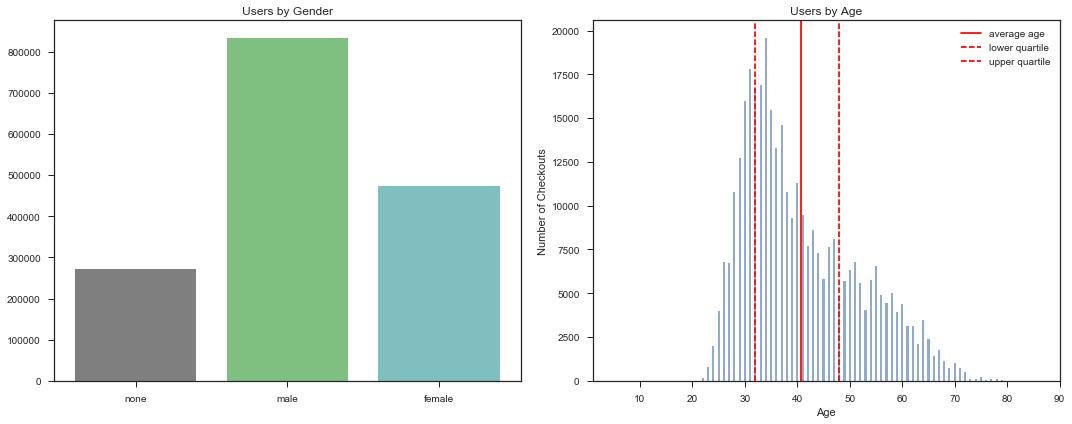

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
gender_counts = np.unique(hubway_data['gender'].replace(np.nan, 'NaN', regex=True).values, return_counts=True)
ax[0].bar(range(3), gender_counts[1], align='center', color=['black', 'green', 'teal'], alpha=0.5)
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(['none', 'male', 'female', ' '])
ax[0].set_title('Users by Gender')

age_col = 2017.0 - hubway_data['birth_date'].dropna().values
age_counts = np.unique(age_col, return_counts=True)
ax[1].bar(age_counts[0], age_counts[1], align='center', width=0.4, alpha=0.6)
ax[1].axvline(x=np.mean(age_col), color='red', label='average age')
ax[1].axvline(x=np.percentile(age_col, 25), color='red', linestyle='--', label='lower quartile')
ax[1].axvline(x=np.percentile(age_col, 75), color='red', linestyle='--', label='upper quartile')
ax[1].set_xlim([1, 90])
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Number of Checkouts')
ax[1].legend()
ax[1].set_title('Users by Age')

plt.tight_layout()
plt.show()

# Where

In [30]:
station_data = pd.read_csv('hubway_stations.csv', low_memory=False)[['id', 'lat', 'lng']]
station_data.head()

,id,lat,lng
0,3,42.340021,-71.100812
1,4,42.345392,-71.069616
2,5,42.341814,-71.090179
3,6,42.361285,-71.065140
4,7,42.353412,-71.044624


In [31]:
hubway_data_with_gps = hubway_data.join(station_data.set_index('id'), on='strt_statn')
hubway_data_with_gps.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,lat,lng
0,1,8,Closed,9,7/28/2011 10:12:00,23,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male,42.359677,-71.059364
1,2,9,Closed,220,7/28/2011 10:21:00,23,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male,42.359677,-71.059364
2,3,10,Closed,56,7/28/2011 10:33:00,23,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male,42.359677,-71.059364
3,4,11,Closed,64,7/28/2011 10:35:00,23,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female,42.359677,-71.059364
4,5,12,Closed,12,7/28/2011 10:37:00,23,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female,42.359677,-71.059364


![Alt](images/Lecture0_g2.png)

# When

In [32]:
#check_out_times = pd.to_datetime(hubway_data['start_date'])
check_out_hours = hubway_data['start_date'].apply(lambda s: int(s[-8:-6]))

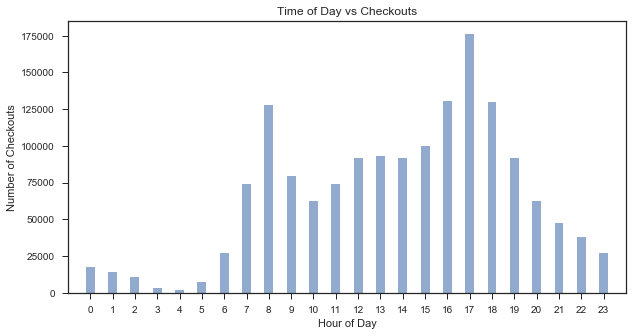

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

check_out_counts = np.unique(check_out_hours, return_counts=True)
ax.bar(check_out_counts[0], check_out_counts[1], align='center', width=0.4, alpha=0.6)
ax.set_xlim([-1, 24])
ax.set_xticks(range(24))
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Checkouts')
ax.set_title('Time of Day vs Checkouts')

plt.show()

# How

In [34]:
def haversine(pt, lat2=42.355589, lon2=-71.060175):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1 = pt[0]
    lat1 = pt[1]
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in miles
    return c * r

In [35]:
station_counts = np.unique(hubway_data_with_gps['strt_statn'].dropna(), return_counts=True)
counts_df = pd.DataFrame({'id':station_counts[0], 'checkouts':station_counts[1]})
counts_df = counts_df.join(station_data.set_index('id'), on='id')
counts_df.head()

,checkouts,id,lat,lng
0,9734,3,42.340021,-71.100812
1,18058,4,42.345392,-71.069616
2,10630,5,42.341814,-71.090179
3,23322,6,42.361285,-71.065140
4,9163,7,42.353412,-71.044624


In [47]:
counts_df.loc[:, 'dist_to_center'] = list(map(haversine, counts_df[['lng', 'lat']].values))
counts_df.head()

,checkouts,id,lat,lng,dist_to_center
0,9734,3,42.340021,-71.100812,2.335706
1,18058,4,42.345392,-71.069616,0.853095
2,10630,5,42.341814,-71.090179,1.802423
3,23322,6,42.361285,-71.065140,0.467803
4,9163,7,42.353412,-71.044624,0.807582


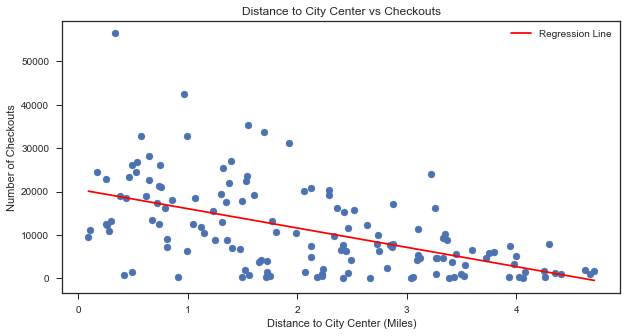

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.scatter(counts_df['dist_to_center'].values, counts_df['checkouts'].values)

reg_line = LinearRegression()
reg_line.fit(counts_df['dist_to_center'].values.reshape((len(counts_df['dist_to_center']), 1)), counts_df['checkouts'].values)

distances = np.linspace(counts_df['dist_to_center'].min(), counts_df['dist_to_center'].max(), 50)

ax.plot(distances, reg_line.predict(distances.reshape((len(distances), 1))), color='red', label='Regression Line')

ax.set_xlabel('Distance to City Center (Miles)')
ax.set_ylabel('Number of Checkouts')
ax.set_title('Distance to City Center vs Checkouts')
ax.legend()

plt.show()